In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from xorca.lib import load_xorca_dataset
# Personal modification to xorca
from __param__ import *
from tools_xorca import complete_dataset, plot_2D_averages, plot_3D_averages
from calculate_xorca import calculate_speed, calculate_psi, calculate_moc, calculate_enso, average_2D, average_3D, average_2D_list

In [2]:
#General definitions
config = 'ORCA1L75'
exp    = 'a13c'
data_path     = Path("/esnas/exp/ecearth/a13c/original_files/19500101/fc0/outputs")
data_path_aux = Path(coordinates_path+config)

#Data files
data_files_u  = list(sorted(data_path.glob(exp+"_1m_200[01]*grid_U.nc")))
data_files_v  = list(sorted(data_path.glob(exp+"_1m_200[01]*grid_V.nc")))
data_files_t  = list(sorted(data_path.glob(exp+"_1m_200[01]*grid_T.nc")))
data_files_sbc  = list(sorted(data_path.glob(exp+"_1m_200[01]*SBC.nc")))
aux_files_m   = list(sorted(data_path_aux.glob("mesh*")))
aux_files_s   = list(sorted(data_path_aux.glob("subbasins.nc")))
aux_files_b   = list(sorted(data_path_aux.glob("basin_mask_ORCA1_ece3.2_2017.nc4")))

data_files    = data_files_u+data_files_v+data_files_t
aux_files     = aux_files_m+aux_files_s+aux_files_b

In [3]:
#Actualy load the data
ds_xorca = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True, 
                              input_ds_chunks=input_chunks_ORCA1L75,
                              target_ds_chunks=target_chunks_ORCA1L75,
                              update_orca_variables=update_orca_variables)

In [4]:
#Add area and volume of the grid to the coordinates
ds_xorca = complete_dataset(ds_xorca)

In [22]:
    list_vars=['pbo','zos']
    masks = [key for key in ds_xorca.coords.keys() if key.startswith('tmask')]
    averages = []
    for mask in masks:
        if mask != 'tmask':
            ds = ds_xorca.where(ds_xorca[mask],drop=True)
        else:
            ds = ds_xorca
        for var in list_vars:
            ave = average_2D(ds,var)
            ave.name=var+'_'+mask+'_2D_ave'
            averages.append(ave)

In [29]:
    ds_out=[]
    for (i,var) in enumerate(list_vars):
        vars = [diag for diag in averages if diag.name.startswith(var)]
        ds_out.append(xr.concat(vars,dim='basins').rename(var+"_2D_ave"))
    ds_out = xr.merge(ds_out)
    ds_out.coords['basins'] = masks
    ds_out_yearly_rolling = ds_out.rolling(t=12, center=True).mean()
    xr.concat((ds_out,ds_out_yearly_rolling),dim='data_type')

<xarray.Dataset>
Dimensions:     (basins: 12, data_type: 2, t: 24)
Coordinates:
  * t           (t) datetime64[ns] 2000-01-16T12:00:00 2000-02-15T12:00:00 ...
  * basins      (basins) <U11 'tmask' 'tmaskatl' 'tmaskind' 'tmaskpac' ...
Dimensions without coordinates: data_type
Data variables:
    pbo_2D_ave  (data_type, basins, t) float64 2.678e+03 2.678e+03 2.678e+03 ...
    zos_2D_ave  (data_type, basins, t) float64 -0.03459 -0.03908 -0.04554 ...

In [5]:
ds_out = average_2D_list(ds_xorca,['pbo','zos'])
ds_out

<xarray.Dataset>
Dimensions:            (basins: 12, t: 24)
Coordinates:
  * t                  (t) datetime64[ns] 2000-01-16T12:00:00 ...
  * basins             (basins) <U11 'tmask' 'tmaskatl' 'tmaskind' ...
Data variables:
    pbo_2D_ave         (basins, t) float64 2.678e+03 2.678e+03 2.678e+03 ...
    zos_2D_ave         (basins, t) float64 -0.03459 -0.03908 -0.04554 ...
    pbo_2D_ave_yearly  (basins, t) float64 nan nan nan nan nan nan 2.678e+03 ...
    zos_2D_ave_yearly  (basins, t) float64 nan nan nan nan nan nan -0.03763 ...

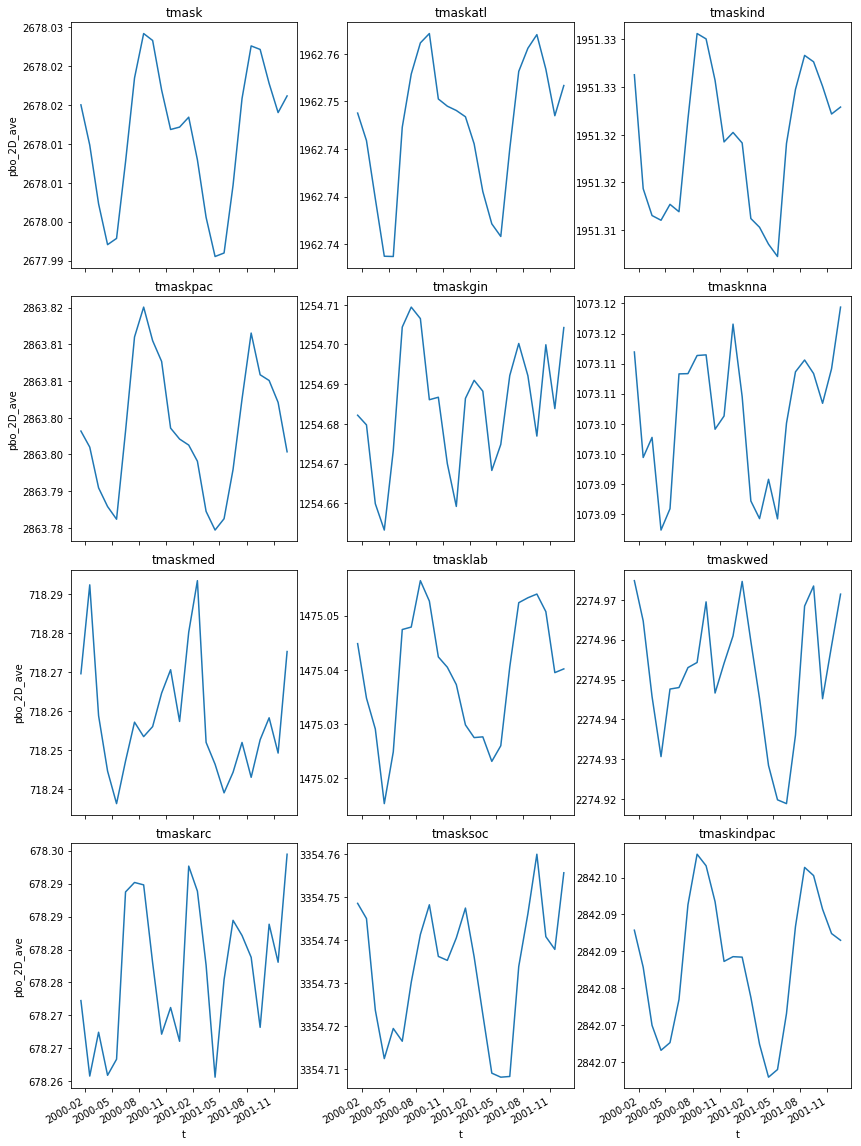

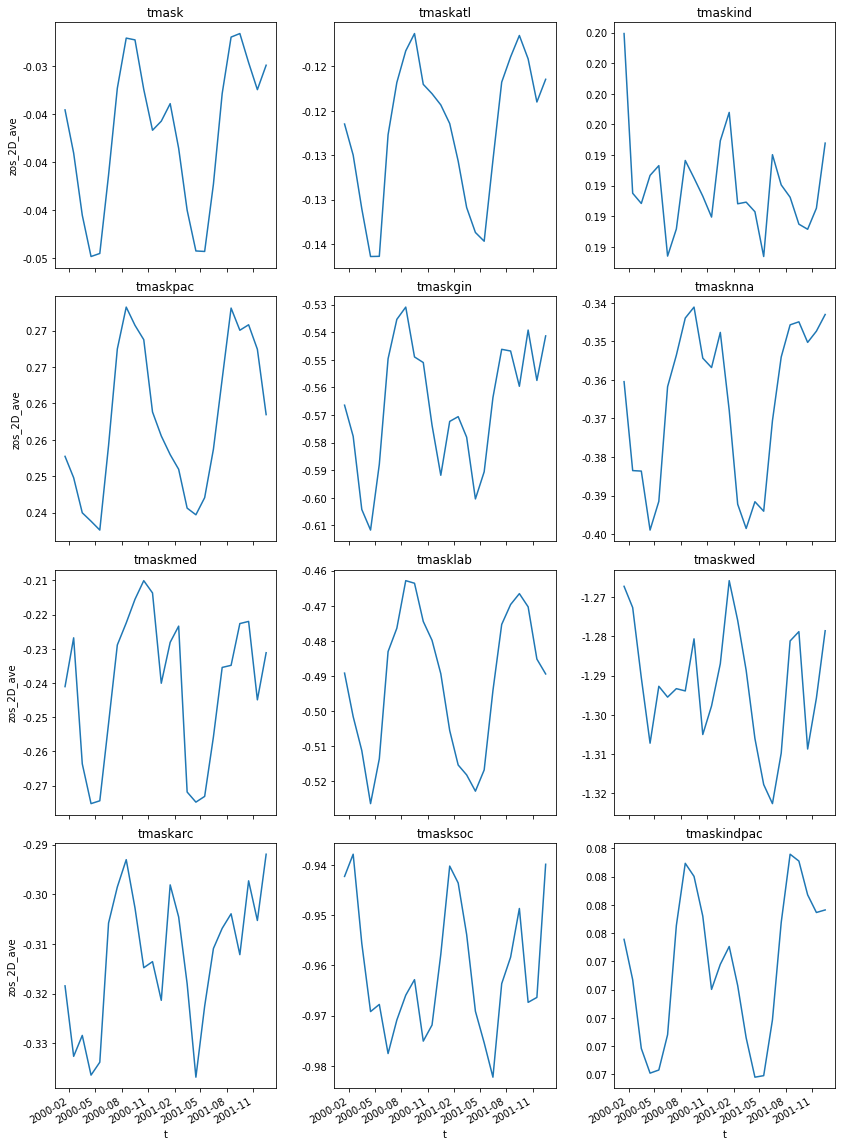

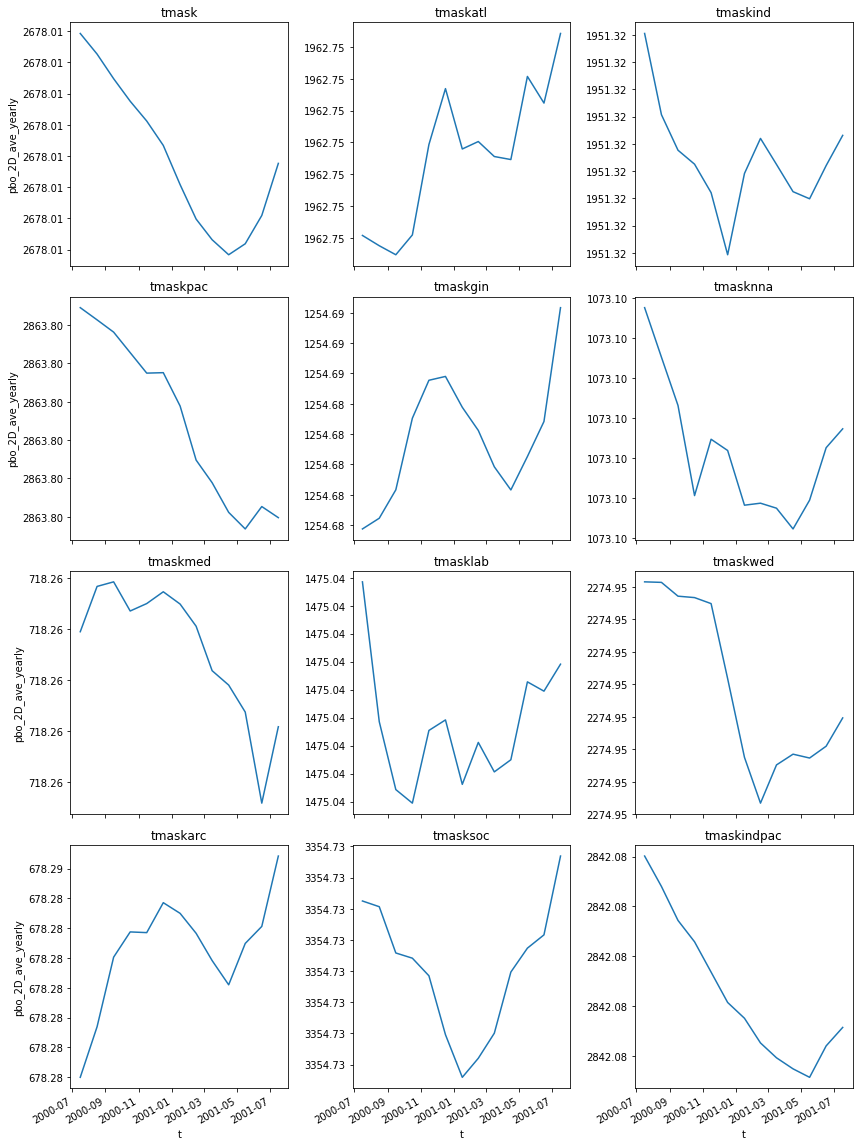

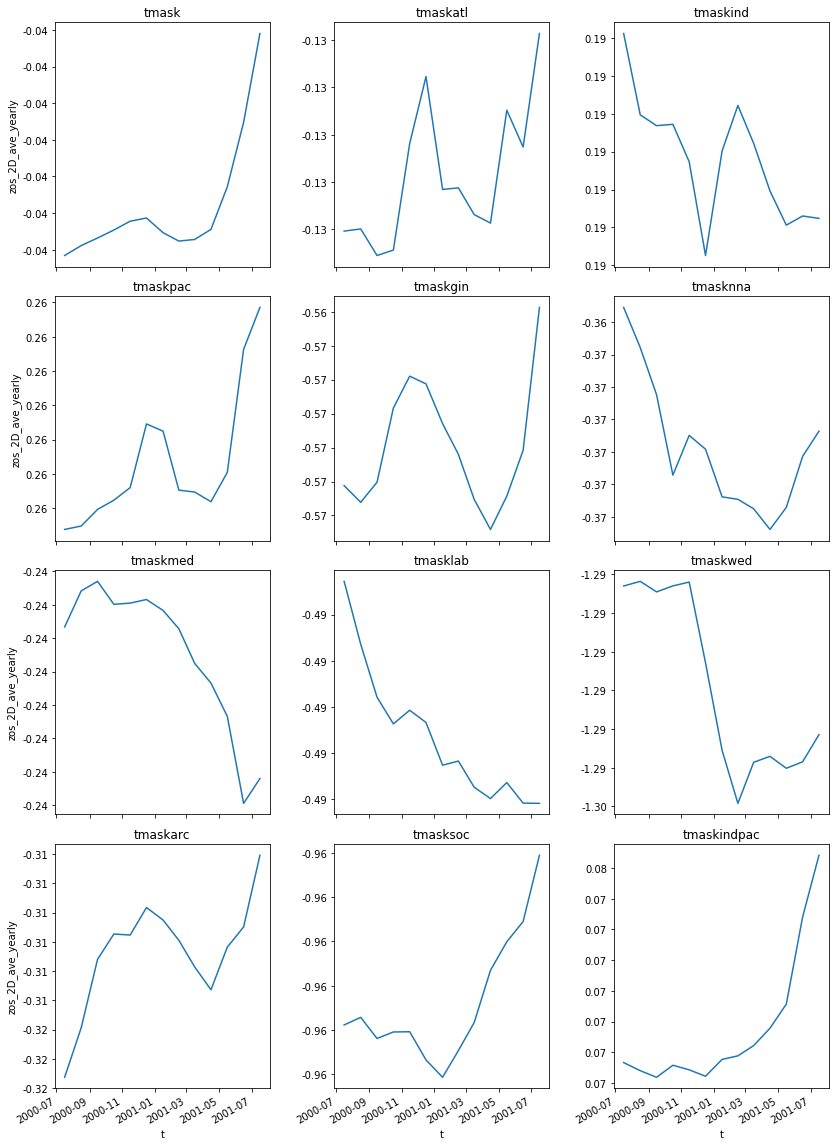

In [6]:
plot_2D_averages(ds_out)

In [16]:
ds_out2 = xr.concat((ds_out.pbo_2D_ave,ds_out.pbo_2D_ave_yearly),dim='data_type')
ds_out2.coords['data_type']=['monthly','yearly_rolling']
ds_out2

<xarray.DataArray 'pbo_2D_ave' (data_type: 2, basins: 12, t: 24)>
array([[[2678.01502 , 2678.009844, ..., 2678.014027, 2678.016168],
        [1962.748773, 1962.74588 , ..., 1962.748496, 1962.751668],
        ...,
        [3354.748575, 3354.745034, ..., 3354.737854, 3354.755697],
        [2842.087865, 2842.082841, ..., 2842.087408, 2842.086496]],

       [[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]]])
Coordinates:
  * t          (t) datetime64[ns] 2000-01-16T12:00:00 2000-02-15T12:00:00 ...
  * basins     (basins) <U11 'tmask' 'tmaskatl' 'tmaskind' 'tmaskpac' ...
  * data_type  (data_type) <U14 'monthly' 'yearly_rolling'

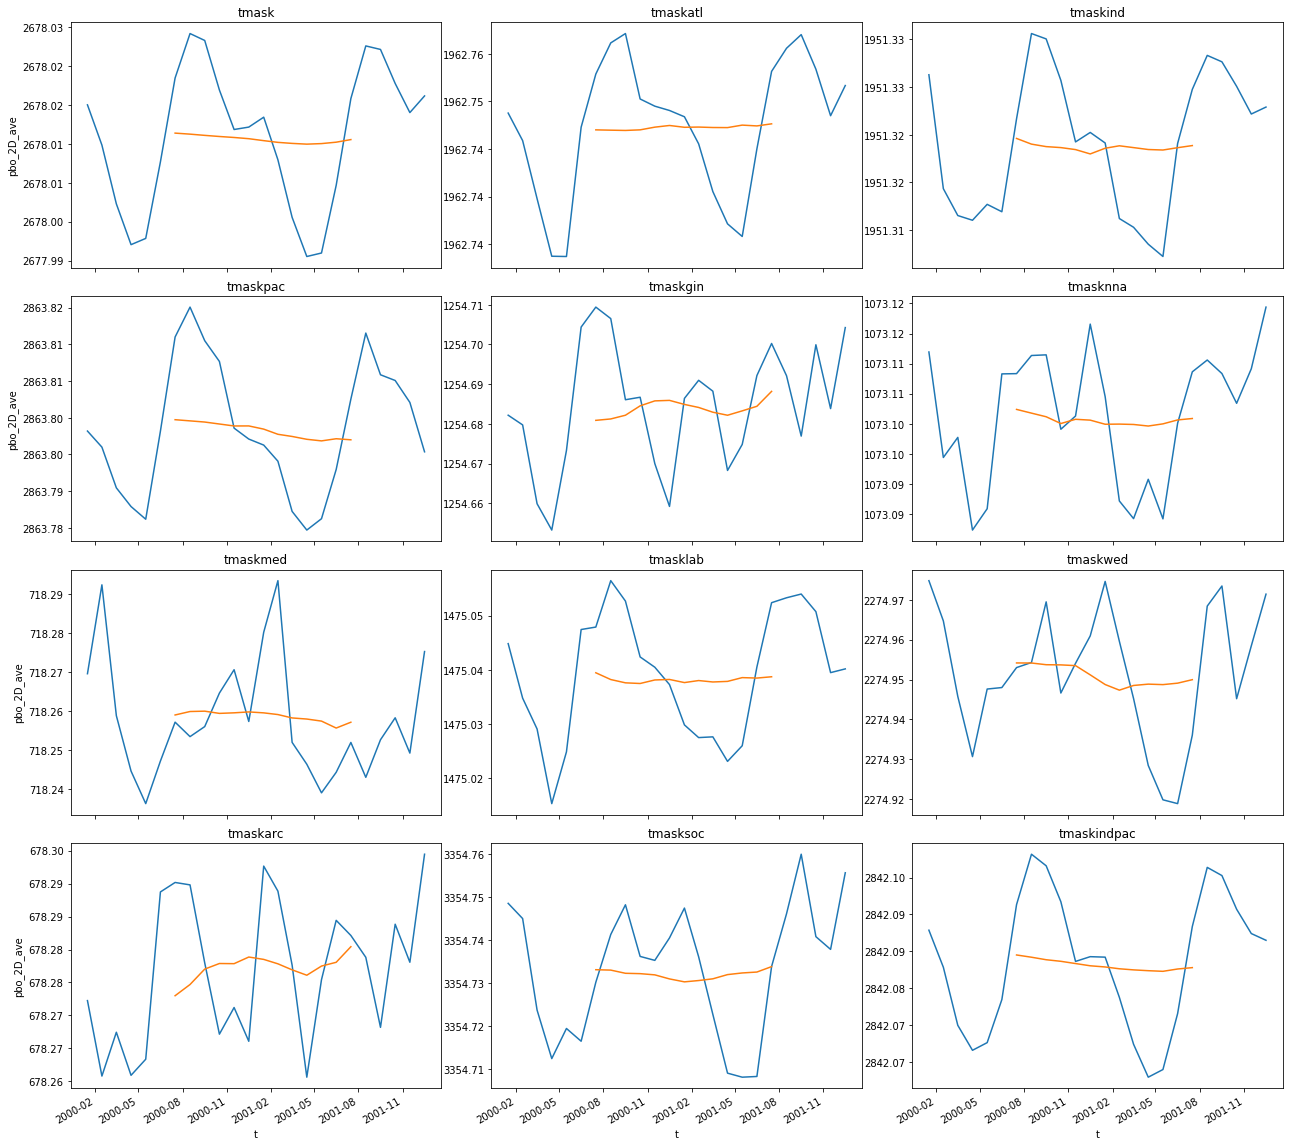

In [21]:
var='pbo_2D_ave'
ax=ds_out2.plot(col='basins',hue='data_type', col_wrap=3,sharey=False, figsize=[18,16],add_legend=False)
for i,g in enumerate(ax.axes.flat):
    g.set_title(ds_out2.basins[i].values)
    vals = g.get_yticks()
    g.set_yticklabels(['{:04.2f}'.format(x) for x in vals])